In [8]:
#Paso 1. Obterner la data


%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
#import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

train = pd.read_csv('train.csv')
test =  pd.read_csv('train.csv')

quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

print("Done...")

Done...


Hay 1460 instancias de datos de entrenamiento y 1460 de datos de prueba. El número total de atributos es igual a 81, de los cuales 36 es cuantitativo, 43 categórico + Id y Precio de venta.

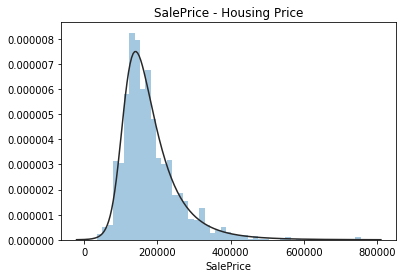

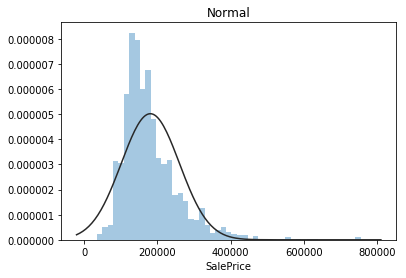

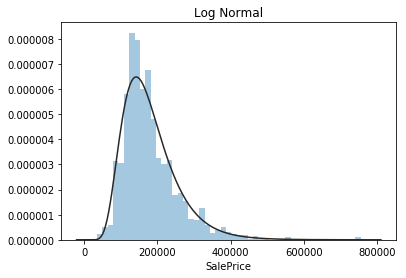

In [9]:
import scipy.stats as st
y = train['SalePrice']
plt.figure(1); plt.title('SalePrice - Housing Price')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

#Es evidente que SalePrice no sigue una distribución normal, 
#por lo que antes de realizar la regresión debe ser transformado. 
#Si bien la transformación log funciona bastante bien, lo mejor es la distribución normal 


In [10]:
#Viendo data Train por columnas
train_CSV_File= pd.read_csv("train.csv")
train_CSV_File.head()

test_CSV_File= pd.read_csv("test.csv")
test_CSV_File.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [11]:
#Viendo la Info de c/columna de Train
train_CSV_File.info()
#Son 81 columnas en total (cualitativas y cuantitativas)
#Tenemos Tipos : int64 float 64 object
#Varias columnas tienen missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

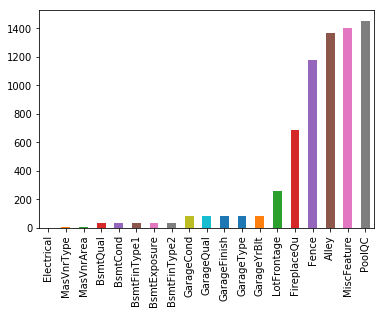

In [12]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

#19 atributos tienen valores faltantes
#Alley i.g solo tiene 91 valores de 1460, por eso su barrita es tan grande
#PoolQC es el atributo al que mpas le falta valores, posee solo 7 datos

In [13]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

#Alley 1460 - 1406 = 91, solo tiene 91 datos

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [14]:
#Viendo Tipo Objeto LotShape
train_CSV_File["LotShape"].value_counts()


Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

In [15]:
#Viendo Tipo Objeto Alley con missing values
train_CSV_File["Alley"].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [16]:
#Función .describe()
train_CSV_File.describe()
#Me da valores com valor más, min , %, un resumen estadístico

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


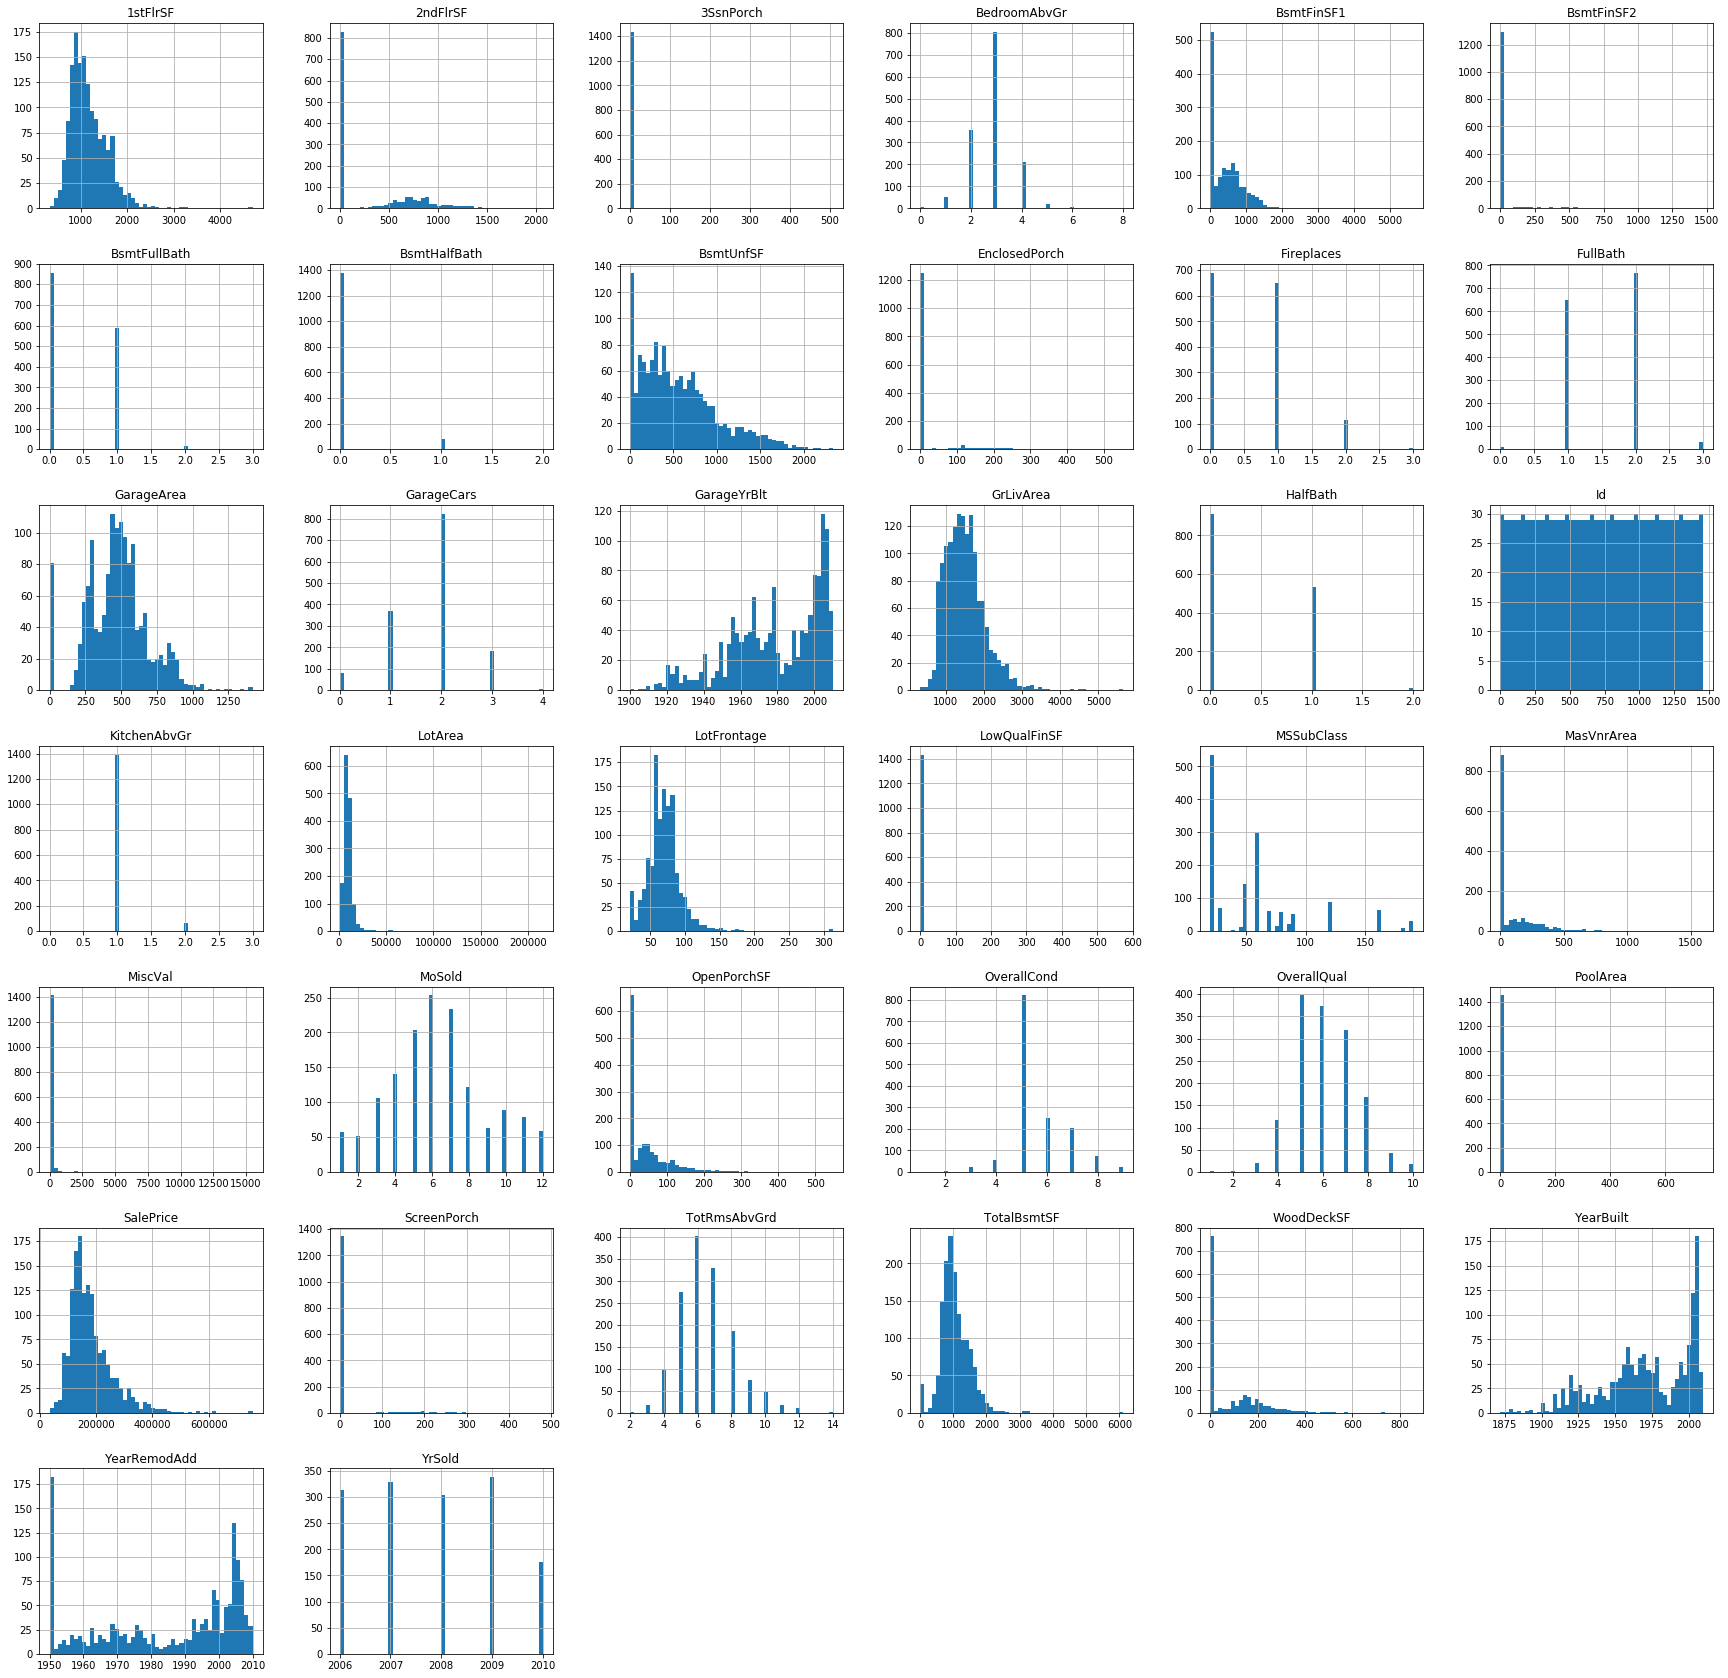

In [17]:
#mostramos los histogramas de algunas columnas, las columnas solitas podrían ser missgin values...
#Solo mans Area parece distribuido completamente Objects types no se muestran, solo 38 histogramas (cuantitativos)
#Objects Cualitativos
%matplotlib inline
import matplotlib.pyplot as plt
train_CSV_File.hist(bins=50, figsize=(30,30))
plt.show()

In [18]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

#Además, ninguna de las variables cuantitativas tiene una distribución normal, 
#por lo que también deben transformarse.

False


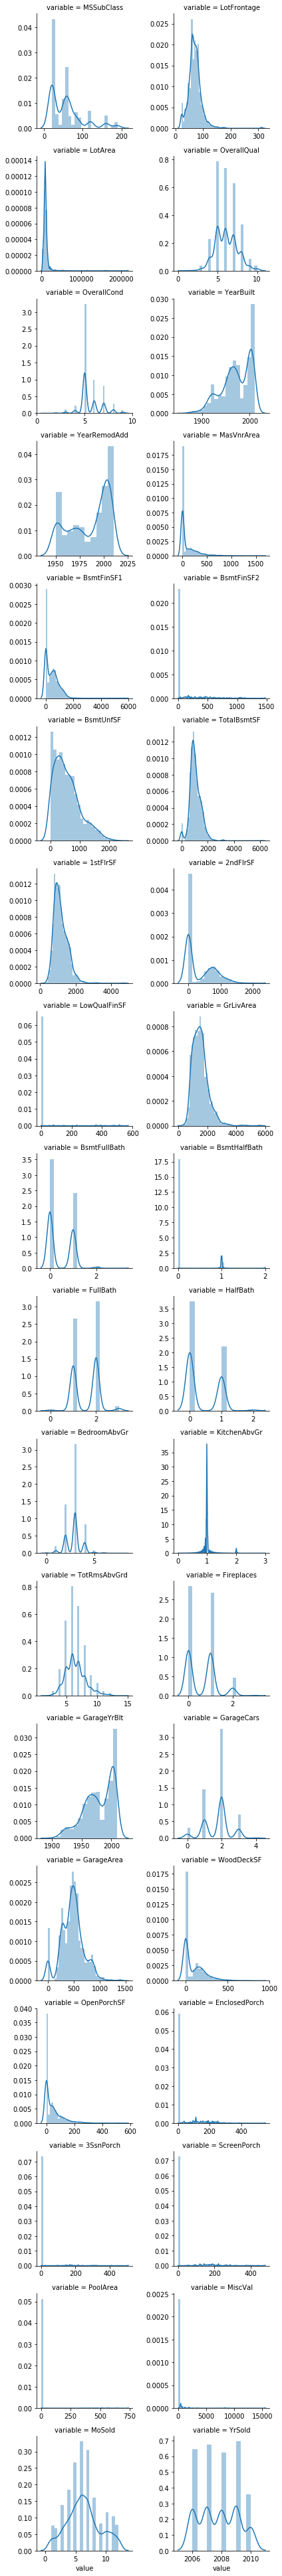

In [19]:
#Muestra solo los valores cuantitativos y nunguno tiene distribución normal

f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")



In [20]:
#Este dataset ya tiene su conjunto de pruebas (Sus datos empiezan desde 1461)
test_CSV_File.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [21]:
test_CSV_File.describe()
#Como vamos a predecir SalePrice solo tiene 37 columnas cuantitativas

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


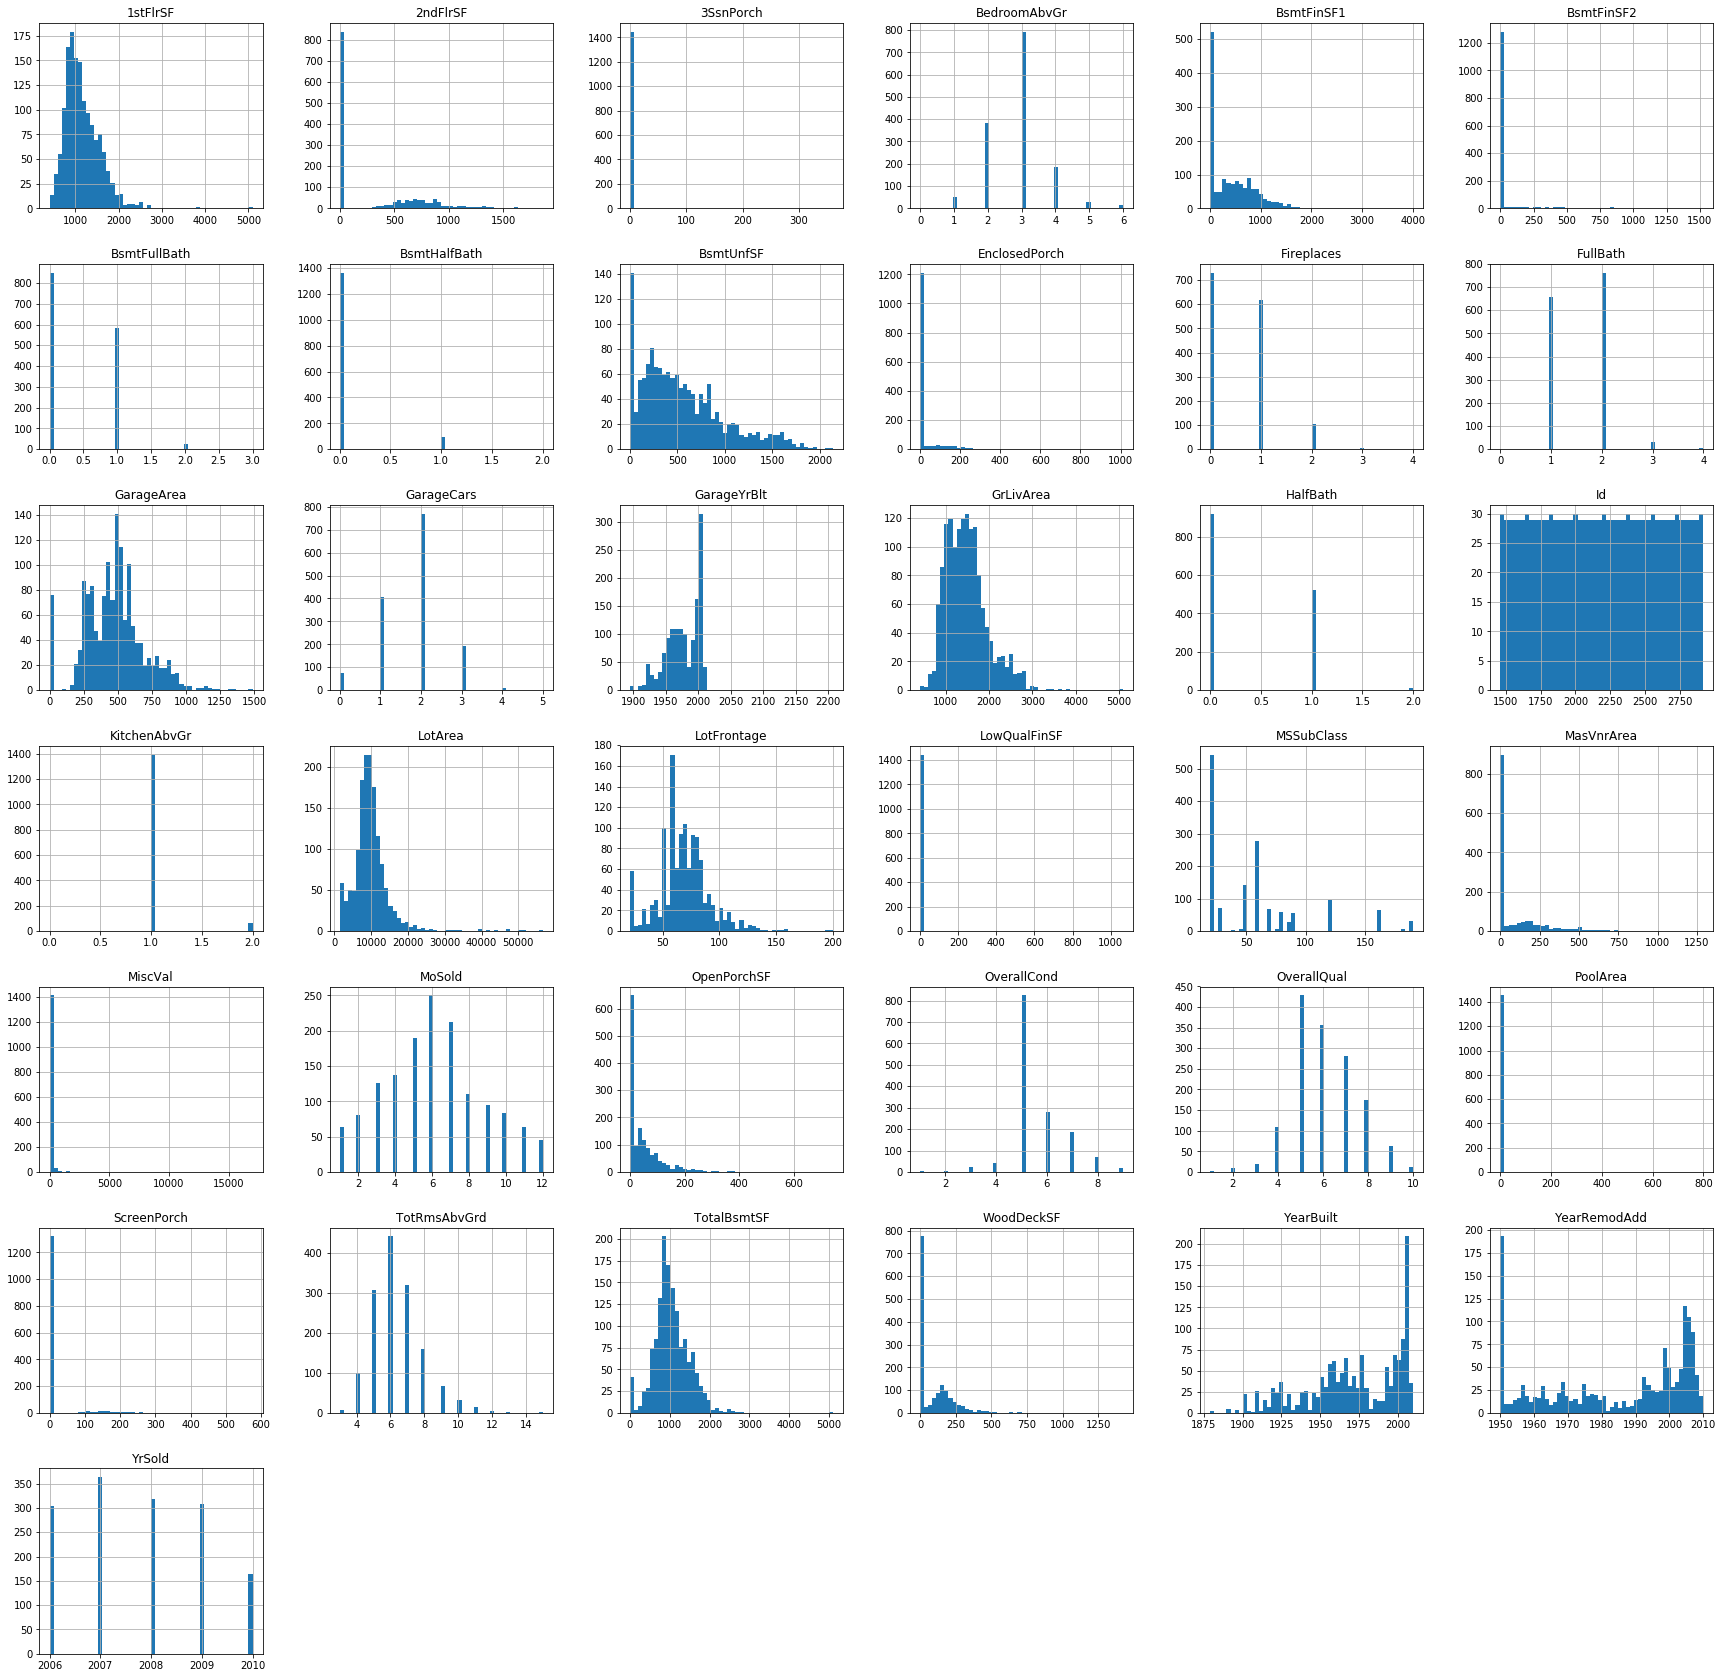

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
test_CSV_File.hist(bins=50, figsize=(30,30))
plt.show()

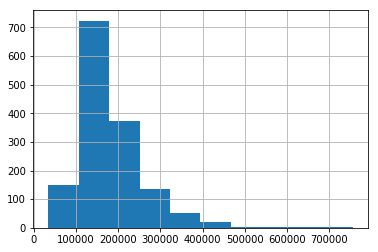

In [23]:
#Qué queremos predecir
train_CSV_File["SalePrice"].hist()

In [24]:
train_CSV_File['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

/home/danielafe7/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


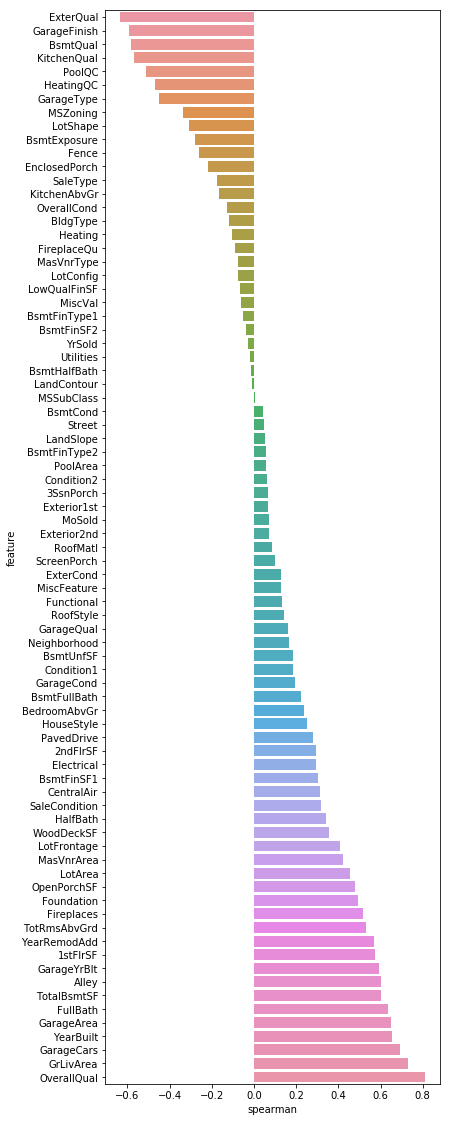

In [25]:
#Paso 2. Explore  the  data  to  gain  insights.

#Cómo saber qué variables se correlacionan más con SalePrice
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qualitative 
spearman(train, features)



In [26]:
#Otra forma de hallar la correlación (bajo esta característica de debería sacar el test_set)
corr_matrix = train_CSV_File.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f52ca798ac8>,
      dtype=object)

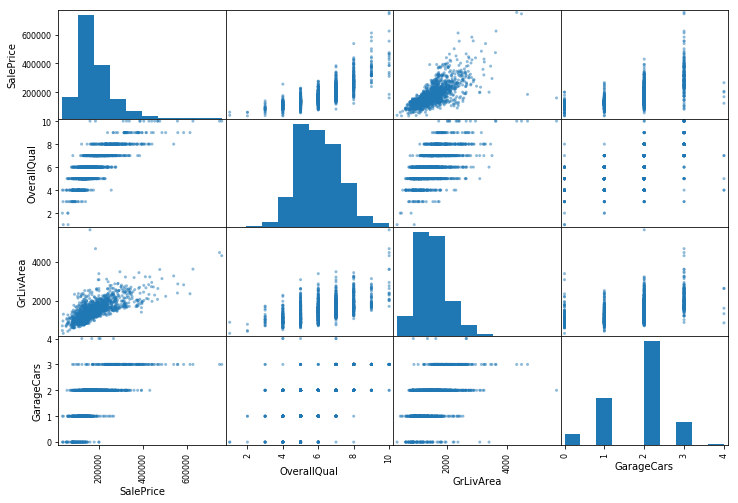

In [27]:
from pandas.plotting import scatter_matrix

attributes = ["SalePrice", "OverallQual", "GrLivArea",
              "GarageCars"]
scatter_matrix(train_CSV_File[attributes], figsize=(12, 8))


In [28]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(test[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

#Ni test, en sus variables cuantitativas tiene una distribución normal, 
#por lo que también deben transformarse.

False


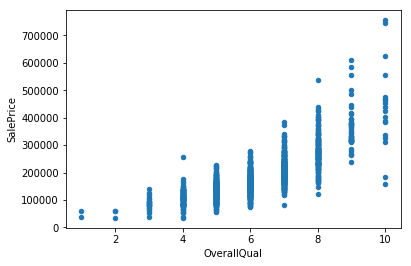

In [29]:
#Se relacionea más con OverallQual
train_CSV_File.plot(kind="scatter", x="OverallQual", y="SalePrice")

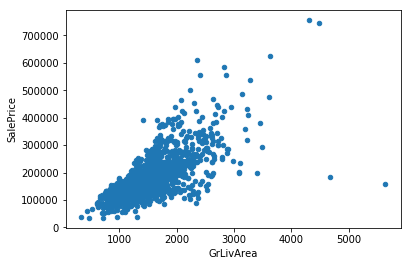

In [30]:
#Se relacionea más con OverallQual y le sigue GrLivArea
train_CSV_File.plot(kind="scatter", x="GrLivArea", y="SalePrice")
# + Grande la casa + cuesta

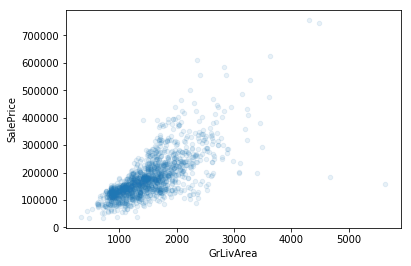

In [31]:
train_CSV_File.plot(kind="scatter", x="GrLivArea", y="SalePrice", alpha=0.1)

In [32]:
#Paso 3. Prepare  the  data  to  better  expose  the  underlying  data
#patterns  to  Machine  Learning  algorithms.
housing = train_CSV_File.drop("SalePrice", axis=1) # drop labels for training set
housing_labels = train_CSV_File["SalePrice"].copy()
print("Exitoso: Se creo un train set (housing) sin SalePrice")

Exitoso: Se creo un train set (housing) sin SalePrice


In [33]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows
#Hace un sample (muestra) de las columnas que tienen missing values i.g Alle, PoolQC
#5 rows × 80 columns

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [34]:
#Te ofrece 2 soluciones, O1. Eliminar las columnas con missing values O2. agregar los valores faltantes con la
#mediana (para esta usaremos un imputer)
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")


In [35]:
housing_num = housing.select_dtypes(include=[np.number]) #Seleccionamos solas las colum numéricas
housing_num.head()
#5 rows × 37 columns

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,548,0,61,0,0,0,0,0,2,2008
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,460,298,0,0,0,0,0,0,5,2007
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,608,0,42,0,0,0,0,0,9,2008
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,642,0,35,272,0,0,0,0,2,2006
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,836,192,84,0,0,0,0,0,12,2008


In [36]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [37]:
imputer.statistics_

array([7.3050e+02, 5.0000e+01, 6.9000e+01, 9.4785e+03, 6.0000e+00,
       5.0000e+00, 1.9730e+03, 1.9940e+03, 0.0000e+00, 3.8350e+02,
       0.0000e+00, 4.7750e+02, 9.9150e+02, 1.0870e+03, 0.0000e+00,
       0.0000e+00, 1.4640e+03, 0.0000e+00, 0.0000e+00, 2.0000e+00,
       0.0000e+00, 3.0000e+00, 1.0000e+00, 6.0000e+00, 1.0000e+00,
       1.9800e+03, 2.0000e+00, 4.8000e+02, 0.0000e+00, 2.5000e+01,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       6.0000e+00, 2.0080e+03])

In [38]:
#Eesto es lo mismo que calcular manualmente la mediana de cada atributo:
housing_num.median().values
#Array de 37 atributos numéricos, obvio solo llenará con la mediana a a quellos
#atributos con missing values

array([7.3050e+02, 5.0000e+01, 6.9000e+01, 9.4785e+03, 6.0000e+00,
       5.0000e+00, 1.9730e+03, 1.9940e+03, 0.0000e+00, 3.8350e+02,
       0.0000e+00, 4.7750e+02, 9.9150e+02, 1.0870e+03, 0.0000e+00,
       0.0000e+00, 1.4640e+03, 0.0000e+00, 0.0000e+00, 2.0000e+00,
       0.0000e+00, 3.0000e+00, 1.0000e+00, 6.0000e+00, 1.0000e+00,
       1.9800e+03, 2.0000e+00, 4.8000e+02, 0.0000e+00, 2.5000e+01,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       6.0000e+00, 2.0080e+03])

In [39]:
#Hasta aquí lo único que hemos hecho es preparar el imputer para que llene missing values
housing_num['LotFrontage'].describe() #Uno de los val numericos con missing values

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [40]:
#Fase de Transformación para aplicar el llenado
X = imputer.transform(housing_num)


In [41]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index = list(housing.index.values))

In [42]:
housing_tr.loc[sample_incomplete_rows.index.values]

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,...,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,...,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,...,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,...,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0


In [43]:
imputer.strategy

'median'

In [44]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,...,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,...,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,...,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,...,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0


In [45]:
#Luego de transformar, recién se llenan los missing values
housing_tr['LotFrontage'].describe() #Se llenaron :)

count    1460.000000
mean       69.863699
std        22.027677
min        21.000000
25%        60.000000
50%        69.000000
75%        79.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [46]:
#Seleccionamos ahora los Atriutos Categóricos
housing_cat = housing.select_dtypes(include=[np.object])
housing_cat.head()
#5 rows × 43 columns

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [47]:
housing_cat['Alley'].describe() #Atributo categóricon con missing values

count       91
unique       2
top       Grvl
freq        50
Name: Alley, dtype: object

In [48]:
#Ya que son del tipo categórico no podemos llenarlo con la mediana pero sí con la moda ...
import sklearn_pandas #instala el paqete por consola pip install sklearn-pandas

In [49]:
from sklearn_pandas import CategoricalImputer
imputer = CategoricalImputer()


In [50]:
for objeto in housing_cat:
    housing_cat[objeto] = imputer.fit_transform(housing_cat[objeto]) #preparamos imputer para clase objet
    
#Si solo poniamos imputer.fit_transform(housing_cat[objeto]) y no 
#housing_cat[objeto] = imputer.fit_transform(housing_cat[objeto])
#Escogia el elemento que mas se repetia en toda la matriz ("NORMAL") y eso es lo que ponía @@


/home/danielafe7/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [51]:
X = imputer.transform(housing_cat)

In [52]:
housing_tr_cat = pd.DataFrame(X, columns=housing_cat.columns,
                          index = list(housing.index.values))

In [53]:
housing_tr_cat.loc[sample_incomplete_rows.index.values]

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
1,RL,Pave,Grvl,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
2,RL,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
3,RL,Pave,Grvl,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Abnorml
4,RL,Pave,Grvl,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal


In [54]:
housing_tr_cat = pd.DataFrame(X, columns=housing_tr_cat.columns)
housing_tr_cat.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
1,RL,Pave,Grvl,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
2,RL,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
3,RL,Pave,Grvl,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Abnorml
4,RL,Pave,Grvl,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal


In [55]:
#Luego de transformar, recién se llenan los missing values
housing_tr_cat['Alley'].describe() #Se llenaron :)

count     1460
unique       2
top       Grvl
freq      1419
Name: Alley, dtype: object

Hasta este punto, la matriz housing_tr y housing_tr_cat   ya no tienen ningún missing value. A continuación trasnformaremos las columnas Categoricas en hotVectors.

In [56]:
h_c = []
h_e = []
for cat in housing_cat:
    housing_cat_encoded, housing_categories = housing_cat[cat].factorize()
    h_c.append(housing_categories)
    h_e.append(housing_cat_encoded)
  


h_e[3][:10] #LotShape pone etiquetas x clase (clase 0 1 2 3 ...)


array([0, 0, 1, 1, 1, 1, 0, 1, 0, 0])

In [57]:
h_c[3][:1460]
#Muestra las clases de la columna categorica LotShape

Index(['Reg', 'IR1', 'IR2', 'IR3'], dtype='object')

In [58]:
from sklearn.preprocessing import OneHotEncoder
h_e_one = []
encoder = OneHotEncoder()

for indice in range(0,len(h_e)):
    housing_cat_1hot = encoder.fit_transform(h_e[indice].reshape(-1,1))
    h_e_one.append(housing_cat_1hot)

h_e_one[3] 

#Muestra los 1460 elelemntos de LotShape y sus 4 clases (hacemos que esas 4 clases se vuelva hot vector 0 o 1)

<1460x4 sparse matrix of type '<class 'numpy.float64'>'
	with 1460 stored elements in Compressed Sparse Row format>

In [59]:
h_e_one_array = []
for cat in range(0,len(h_e_one)):   
    h_e_one_array.append(h_e_one[cat].toarray())


In [60]:
h_e_one_array[3]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

Hasta aquí tenemos dos matrices transformadas, una numérica y otra categórica. Puedes ahorrarte todo esto, simplemente con los pipeline :(

In [61]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [63]:
#Usando LabelEncoder
from sklearn import preprocessing
for i in range(housing.shape[1]):
    if housing.iloc[:,i].dtypes == object:
        lbl = LabelEncoder()
        lbl.fit(list(housing.iloc[:,i].values) )
        housing.iloc[:,i] = lbl.transform(list(housing.iloc[:,i].values))
housing  

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,0,3,4,4,0,2,2008,8,4
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,0,3,4,4,0,5,2007,8,4
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,0,3,4,4,0,9,2008,8,4
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,0,3,4,4,0,2,2006,8,0
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,0,3,4,4,0,12,2008,8,4
5,6,50,3,85.0,14115,1,2,0,3,0,...,0,0,3,2,2,700,10,2009,8,4
6,7,20,3,75.0,10084,1,2,3,3,0,...,0,0,3,4,4,0,8,2007,8,4
7,8,60,3,NaN,10382,1,2,0,3,0,...,0,0,3,4,2,350,11,2009,8,4
8,9,50,4,51.0,6120,1,2,3,3,0,...,0,0,3,4,4,0,4,2008,8,0
9,10,190,3,50.0,7420,1,2,3,3,0,...,0,0,3,4,4,0,1,2008,8,4


In [64]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


num_attribs = list(housing.select_dtypes(include=[np.number])) #Le pasamos los numéricos no llenitos, 
cat_attribs = list(housing.select_dtypes(include=[np.object])) #Le pasamos los categóricos no llenitos

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()), #De pasito escalamos valores
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        #('imputer', CategoricalImputer()),
        #('cat_encoder', CategoricalEncoder()),
    ])

In [65]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [66]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.73086488,  0.07337496, -0.04553194, ...,  0.13877749,
         0.31386709,  0.2085023 ],
       [-1.7284922 , -0.87256276, -0.04553194, ..., -0.61443862,
         0.31386709,  0.2085023 ],
       [-1.72611953,  0.07337496, -0.04553194, ...,  0.13877749,
         0.31386709,  0.2085023 ],
       ...,
       [ 1.72611953,  0.30985939, -0.04553194, ...,  1.64520971,
         0.31386709,  0.2085023 ],
       [ 1.7284922 , -0.87256276, -0.04553194, ...,  1.64520971,
         0.31386709,  0.2085023 ],
       [ 1.73086488, -0.87256276, -0.04553194, ...,  0.13877749,
         0.31386709,  0.2085023 ]])

In [67]:
housing_labels.shape

(1460,)

In [68]:
housing_prepared.shape


(1460, 80)

In [69]:
#Paso 4. Select and train a model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [70]:
# Vemos las predicciones con algunos datos los primeros 5
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data) #Transformamos algunos daditos del dataset

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [216319.27866533 201090.77764607 219373.78786578 173301.49332454
 288170.03969136]


In [71]:
print("Labels:", list(some_labels)) #Nada mal

Labels: [208500, 181500, 223500, 140000, 250000]


In [72]:
some_data_prepared

array([[-1.73086488,  0.07337496, -0.04553194, -0.22087509, -0.20714171,
         0.06423821,  0.24471681,  0.75073056,  0.31466687, -0.02618016,
         0.60466978, -0.22571613, -1.20621453, -0.03628912, -0.03174026,
        -0.41169079,  1.02668924,  0.65147924, -0.51719981,  1.05099379,
         0.87866809, -0.49151573, -0.12579688,  0.74309239,  0.75162623,
        -1.21648536,  0.51410389, -0.77797579,  0.36420746,  0.83559903,
        -0.33983046,  0.23293722,  0.59190549, -0.43498906,  0.57542484,
         0.27284684, -0.28865283, -0.94459061, -0.45930254, -0.12304604,
        -0.88465767,  0.26381257,  0.30159884, -0.79343379,  1.16185159,
        -0.12024172,  0.37033344,  1.10781015, -0.24106104,  0.78974052,
         1.22758538,  0.16377912, -0.21145358, -0.40936914,  0.91220977,
         0.25597761, -0.95122649,  0.85464957, -0.76873633,  1.01759808,
        -0.31847458,  0.31172464,  0.35100032,  0.11211039,  0.06889955,
         0.28974476, -0.75217584,  0.21650316, -0.3

In [73]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared) #Ya con todos los datos preparados (housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print("El error (RMSE) de regresión lineal es: ",lin_rmse)

El error (RMSE) de regresión lineal es:  30238.676748151447


In [74]:
from sklearn.metrics import mean_absolute_error
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
print("El error (absoluto) de regresión lineal es: ",lin_mae)


El error (absoluto) de regresión lineal es:  18540.62920792816


In [75]:
#Funcion Costo Vectorizado
def costoV(X,Y,theta):
    costo = np.dot ((np.dot(X,theta) - Y).T,(np.dot(X,theta) - Y)) # (X*Theta -Y).T * (X*Theta -Y)
    return costo / 2

In [76]:
#Funcion Gradiente Vectorizada
def gradienteV(X,Y,theta,alpha,num_iter):
    for i in range(num_iter):
        #c = costoV(X,Y,theta)
        #print("Coso en iter ",i," es: ",c)
        h_theta = (np.dot(X,theta) - Y)  #Vector Columna h_t = (X.Theta -Y)
        tmp = h_theta * X                
        gamma =  np.sum(tmp, axis=0).reshape(theta.shape[0],1) #Sum(h_t)*X
        theta = theta - ((alpha/X.shape[0]) * gamma)
        
    c = costoV(X,Y,theta)
    #print("Costo con theta Final es: ",c)    
    return theta

In [77]:
tamTheta = housing_prepared.shape[1] 
theta = np.zeros(tamTheta).reshape((tamTheta,1))
housing_labels = housing_labels.reshape(len(housing_labels),1)
theta = gradienteV(housing_prepared,housing_labels,theta,0.01,30000)

/home/danielafe7/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [78]:
def predicciones(X,theta):
    predic = (np.dot(X,theta))
    return predic

In [79]:
_predi = predicciones(housing_prepared,theta)
print(_predi[:5])
print("Predictions:", lin_reg.predict(some_data_prepared))

[[ 35489.63351813]
 [ 20156.67510745]
 [ 38284.99786266]
 [ -7705.74868376]
 [107160.61479085]]
Predictions: [216319.27866533 201090.77764607 219373.78786578 173301.49332454
 288170.03969136]


In [80]:
print("Labels:", housing_labels[:5]) #Nada mal

Labels: [[208500]
 [181500]
 [223500]
 [140000]
 [250000]]


In [81]:
lin_mse = mean_squared_error(housing_labels, _predi)
lin_rmse = np.sqrt(lin_mse)
print("El error (RMSE) de nuestra regresión lineal es: ",lin_rmse)

El error (RMSE) de nuestra regresión lineal es:  183431.28244689974


In [82]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, _predi)
print("El error (absoluto) de nuestra regresión lineal es: ",lin_mae)

El error (absoluto) de nuestra regresión lineal es:  181393.99848013333


In [83]:
#Escogiendo un mejor Modelo
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [84]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print("El error (RMSE) de DecisionTreeRegressor: ",lin_mae)


El error (RMSE) de DecisionTreeRegressor:  181393.99848013333


In [85]:
housing_predictions = tree_reg.predict(housing_prepared)
lin_mae = mean_absolute_error(housing_labels, _predi)
print("El error (absoluto) de DecisionTreeRegressor: lineal es: ",lin_mae)

El error (absoluto) de DecisionTreeRegressor: lineal es:  181393.99848013333


In [86]:
#Escogiendo un mejor Modelo
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [87]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

12061.49541808475

El modelo RandomForestRegressor  es el que mejor funciona en este data_set (tiene un menor RMSE)

In [88]:
#Paso 5.Fine-tune your model
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [89]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels.ravel(),
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [27484.38349851 28106.92746405 24046.09657709 35438.47181834
 34962.69675902 26786.5620135  26446.39220483 24715.53663358
 44739.43114966 29093.31232596]
Mean: 30181.981044453896
Standard deviation: 6067.849356183399



Se ha realizado cross validation del modelo RandomForestRegressor, queremos elegir los mejores parámetros, para ello hacemos usp de GridSearchCV.


In [90]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

La mejor combinación de hiperparestero encontrada:

In [91]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [92]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)


Con los hiperparámetros escogidos, probamos el mejor modelo en el test_set


In [93]:
final_model = grid_search.best_estimator_

In [94]:
test_CSV_File.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [95]:
test_CSV_File.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

Vemos cómo es que en el test_set también hay missing values, por lo que es necesario aplicar el pipeline.

In [96]:
X_test = test_CSV_File
#Y_labels = train_CSV_File["SalePrice"].copy()
print("Exitoso: Se creo un train set (Xtest) sin SalePrice")
X_test.head()

Exitoso: Se creo un train set (Xtest) sin SalePrice


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Aplicando LabelEncoder y Pipeline a Data Test

In [97]:
from sklearn import preprocessing
for i in range(X_test.shape[1]):
    if X_test.iloc[:,i].dtypes == object:
        lbl = LabelEncoder()
        lbl.fit(list(X_test.iloc[:,i].values) )
        X_test.iloc[:,i] = lbl.transform(list(X_test.iloc[:,i].values))
        


In [98]:
X_test_prepared = full_pipeline.fit_transform(X_test)
X_test_prepared


array([[-1.73086406, -0.87471081, -1.49289614, ...,  1.71390537,
         0.32424468,  0.20138321],
       [-1.72848977, -0.87471081, -0.04659105, ...,  1.71390537,
         0.32424468,  0.20138321],
       [-1.72611547,  0.06135085, -0.04659105, ...,  1.71390537,
         0.32424468,  0.20138321],
       ...,
       [ 1.72611547, -0.87471081, -0.04659105, ..., -1.35995811,
         0.32424468, -3.58981811],
       [ 1.72848977,  0.64638939, -0.04659105, ..., -1.35995811,
         0.32424468,  0.20138321],
       [ 1.73086406,  0.06135085, -0.04659105, ..., -1.35995811,
         0.32424468,  0.20138321]])

In [99]:
X_test_prepared.shape

(1459, 80)

In [100]:
final_predictions = final_model.predict(X_test_prepared)

In [102]:
#Cargando labels para test 
test_labels = pd.read_csv('sample_submission.csv')
test_y = test_labels["SalePrice"].copy()
test_ids = test_labels["Id"].copy()
test_y

0       169277.052498
1       187758.393989
2       183583.683570
3       179317.477511
4       150730.079977
5       177150.989247
6       172070.659229
7       175110.956520
8       162011.698832
9       160726.247831
10      157933.279456
11      145291.245020
12      159672.017632
13      164167.518302
14      150891.638244
15      179460.965187
16      185034.628914
17      182352.192645
18      183053.458214
19      187823.339254
20      186544.114328
21      158230.775205
22      190552.829321
23      147183.674872
24      185855.300905
25      174350.470677
26      201740.620691
27      162986.378896
28      162330.199086
29      165845.938617
30      180929.622877
31      163481.501520
32      187798.076714
33      198822.198943
34      194868.409900
35      152605.298564
36      147797.702837
37      150521.968993
38      146991.630154
39      150306.307815
40      151164.372535
41      151133.706961
42      156214.042541
43      171992.760735
44      173214.912550
45      19

In [103]:
final_mse = mean_squared_error(test_y, final_predictions)
final_rmse = np.sqrt(final_mse)

In [104]:
final_rmse

67509.21973992903

In [105]:
for i in final_predictions:
    print(i)

119768.6
154711.66666666666
174184.56666666668
181433.33333333334
185998.0
193121.33333333334
181525.0
178146.66666666666
172941.1
128928.33333333333
208365.4
99750.0
103597.73333333334
153843.33333333334
131061.66666666667
396656.86666666664
246599.0
314527.3
318905.3333333333
447860.6666666667
334875.0
203622.83333333334
189633.3
189327.73333333334
178433.73333333334
203571.33333333334
302683.3
235900.7
217366.0
231906.96666666667
203460.0
108453.33333333333
193670.0
303538.1
289242.26666666666
246608.06666666668
184307.16666666666
160501.7
160555.03333333333
166262.16666666666
178020.0
160070.83333333334
284577.7
235815.36666666667
228563.93333333332
188800.16666666666
245865.33333333334
202423.33333333334
162390.1
156483.33333333334
154010.0
168668.33333333334
168858.8
163060.16666666666
196540.0
154478.33333333334
153217.5
139160.8
230267.16666666666
135370.0
143913.33333333334
164603.33333333334
123146.93333333333
119841.93333333333
133455.0
131691.66666666666
108756.7
129955.833

In [106]:
for i in test_ids:
    print(i)

1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660


In [275]:
submission = pd.DataFrame({
    "Id": test_ids,
    "SalePrice": final_predictions
})
submission.to_csv('submission_test.csv', index=False)



In [133]:
#Realizando prediccion con nuestro modelo test_set
_predi_final = predicciones(X_test_prepared,theta)


In [134]:
_predi_f = []
for i in range(0,len(_predi_final)):
    _predi_f.append(_predi_final[i][0])
    #print(_predi_final[i][0])

In [135]:
_predi_f

[-71845.06722638011,
 -22535.392346589426,
 -9040.335301615049,
 7431.743739566648,
 5435.0678747416005,
 -5703.560728421392,
 4120.016702287408,
 -15922.174316997063,
 18906.52509763788,
 -71196.39174439906,
 18749.50341579057,
 -71973.7023497532,
 -88273.07730735252,
 -34406.84110251805,
 -77151.67730891316,
 172145.20795263594,
 62145.107593622226,
 123588.63585526338,
 119451.71319731332,
 248195.29141909617,
 103662.44052081081,
 33477.38011900348,
 860.1504944566929,
 -14497.404148014317,
 24815.904131507144,
 32916.4154059565,
 119709.3927843846,
 55259.669350218166,
 6511.555726516532,
 62500.3599514701,
 39488.51339461491,
 -81591.26301434876,
 21942.913663329025,
 114385.52978964927,
 89376.56530048554,
 67341.14661117639,
 -14241.757026642015,
 -8401.742599720965,
 -16481.68898151295,
 -20220.841051652937,
 25615.42070802866,
 -35469.61684641821,
 102752.35438686171,
 63839.48079128127,
 44099.91235753138,
 17627.346075534686,
 71801.42033357834,
 30050.293777487826,
 -26663

In [136]:
submission = pd.DataFrame({
    "Id": test_ids,
    "SalePrice": _predi_f[:]
})
submission.to_csv('submission_test_our_model.csv', index=False)
